In [4]:
import tensorflow as tf
print(tf.version.VERSION)

2.2.0


In [5]:
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Unsupervised Hierarchical Disentanglement for Fine Grained Object Generation.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import pickle
import random

import numpy as np
import pandas as pd
import tensorflow as tf

assert tf.version.VERSION.startswith('2.')

from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU, Activation, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Dense, concatenate
from tensorflow.keras.layers import Flatten, Lambda, Reshape, ZeroPadding2D, add, dot, ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def child_to_parent(child_code, child_classes, parent_classes):
    """Returns the parent conditional code"""
    ratio = child_classes/parent_classes
    child_code = tf.cast(child_code, dtype=tf.float32)
    arg_parent = tf.math.argmax(child_code, axis=1)/int(ratio)
    parent_code = tf.zeros([child_code.shape[0], parent_classes])
        
    for i in range(child_code.shape[0]):
        parent_code[i][arg_parent[i]] = 1
    return parent_code


class ParentChildEncoder(tf.keras.layers.Layer):
    """Encoder for parent and child images"""
    def __init__(self, num_disc_features, **kwargs):
        super(ParentChildEncoder, self).__init__(**kwargs)
        self.num_disc_features = num_disc_features

    def call(self, inputs):
        x = ZeroPadding2D(1)(inputs)
        x = Conv2D(self.num_disc_features, 4, 2, use_bias=False)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = ZeroPadding2D(1)(x)
        x = Conv2D(self.num_disc_features*2, 4, 2, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = ZeroPadding2D(1)(x)
        x = Conv2D(self.num_disc_features*4, 4, 2, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = ZeroPadding2D(1)(x)
        x = Conv2D(self.num_disc_features*8, 4, 2, use_bias=False)(x)
        x = BatchNormalization()(x)
        return LeakyReLU(alpha=0.2)(x)


class BackgroundEncoder(tf.keras.layers.Layer):
    """Encoder for the background image"""
    def __init__(self, num_disc_features, **kwargs):
        super(BackgroundEncoder, self).__init__(**kwargs)
        self.num_disc_features = num_disc_features

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        x = Conv2D(self.num_disc_features, 4, 2, use_bias=False)(inputs)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(self.num_disc_features*2, 4, 2, use_bias=False)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(self.num_disc_features*4, 4, 1, use_bias=False)(x)
        return LeakyReLU(alpha=0.2)(x)


class UpSampleBlock(tf.keras.layers.Layer):
    def __init__(self, filters=16, **kwargs):
        super(UpSampleBlock, self).__init__(**kwargs)
        self.filters = filters
        
    def call(self, inputs):
        x = UpSampling2D(size=2, interpolation="nearest")(inputs)
        x = Conv2D(self.filters*2, 3, padding='same', kernel_initializer="orthogonal")(x)
        x = BatchNormalization()(x)
        return ELU()(x)


class DownSampleBlock(tf.keras.layers.Layer):
    def __init__(self, filters=16, **kwargs):
        super(DownSampleBlock, self).__init__(**kwargs)
        self.filters = filters

    def call(self, inputs):
        x = ZeroPadding2D(1)(inputs)
        x = Conv2D(self.filters, 4, 2, use_bias=False)(x)
        x = BatchNormalization()(x)
        return LeakyReLU(alpha=0.2)(x)


class KeepDimsBlock(tf.keras.layers.Layer):
    def __init__(self, filters=16, **kwargs):
        super(KeepDimsBlock, self).__init__(**kwargs)
        self.filters = filters

    def call(self, inputs):
        x = Conv2D(self.filters*2, 3, padding='same', kernel_initializer='orthogonal', use_bias=False)(inputs)
        BatchNormalization()(x)
        return ELU()(x)


class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, channels=16, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.channels = channels

    def call(self, inputs):
        residual = inputs
        x = Conv2D(filters=self.channels * 2, kernel_size=3, strides=1, padding='same', kernel_initializer='orthogonal', 
            use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ELU()(x)
        x = Conv2D(filters=self.channels * 2, kernel_size=3, strides=1, padding='same', kernel_initializer='orthogonal', 
            use_bias=False)(x)
        
        x = BatchNormalization()(x)
        return tf.keras.layers.Add()([x, residual])


class InitGenerator(tf.keras.Model):
    def __init__(self, cfg, gen_dims, condition_flag, **kwargs):
        super(InitGenerator, self).__init__(**kwargs)
        self.gf_dim = gen_dims
        self.condition_flag = condition_flag

        if self.condition_flag==1 :
            self.input_dims = cfg.GAN['Z_DIM'] + cfg.SUPER_CATEGORIES
        elif self.condition_flag==2:
            self.input_dims = cfg.GAN['Z_DIM'] + cfg.FINE_GRAINED_CATEGORIES 

        self.layer1 = UpSampleBlock(self.gf_dim // 2)
        self.layer2 = UpSampleBlock(self.gf_dim // 4)
        self.layer3 = UpSampleBlock(self.gf_dim // 8)
        self.layer4 = UpSampleBlock(self.gf_dim // 16)
        self.layer5 = UpSampleBlock(self.gf_dim // 16)

    def call(self, z_code, h_code):
        z_code = tf.cast(z_code, dtype=tf.float32)
        h_code = tf.cast(h_code, dtype=tf.float32)
        x = Concatenate()([z_code, h_code])
        x = Dense(self.gf_dim*4*4*1, kernel_initializer='orthogonal', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ELU()(x)
        x = Reshape((4, 4, self.gf_dim))(x)
        # print(f'InitGen after reshape: {x.shape}')
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.layer5(x)


class IntermediateGenerator(tf.keras.Model):
    def __init__(self, cfg, gen_dims, hrc=1, num_residual=cfg.GAN['R_NUM'], **kwargs):
        super(IntermediateGenerator, self).__init__(**kwargs)
        self.gf_dim = gen_dims
        self.res = num_residual
        if hrc == 1:
            self.ef_dim = cfg.SUPER_CATEGORIES
        else:
            self.ef_dim = cfg.FINE_GRAINED_CATEGORIES

        self.convblock = Sequential([
            Conv2D(self.gf_dim*2, 3, padding='same', kernel_initializer='orthogonal', use_bias=False),
            BatchNormalization(),
            Activation('relu')
        ])
        self.residual = self.make_layer(ResidualBlock, self.gf_dim)
        self.keepdims = KeepDimsBlock(self.gf_dim // 2)

    def make_layer(self, block, channel_num):
        return Sequential([block(channel_num),
                          block(channel_num)])

    def call(self, h_code, code):
        s_size = h_code.shape[1]
        code = Reshape([1, 1, self.ef_dim])(code)
        # print(f'IntermediateGen after reshape: {code.shape}')
        code = tf.tile(code, tf.constant([1, s_size, s_size, 1]))
        # print(f'IntermediateGen after tile: {code.shape}')
        h_code = tf.cast(h_code, dtype=tf.float32)
        # print(f'IntermediateGen h_code shape: {h_code.shape}')
        code = tf.cast(code, dtype=tf.float32)
        x = Concatenate(axis=-1)([code, h_code])
        x = self.convblock(x)
        x = self.residual(x)
        return self.keepdims(x)


class GetImage(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GetImage, self).__init__(**kwargs)
        self.out_image = Sequential([
            ZeroPadding2D(1),
            Conv2D(filters=3, kernel_size=3, strides=1, kernel_initializer='orthogonal', 
            use_bias=False),
            Activation('tanh')
        ])

    def call(self, inputs):
        return self.out_image(inputs)


class GetMask(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GetMask, self).__init__(**kwargs)
        self.out_mask = Sequential([
            ZeroPadding2D(1),
            Conv2D(filters=1, kernel_size=3, strides=1, kernel_initializer='orthogonal', 
            use_bias=False),
            Activation('sigmoid')
        ])

    def call(self, inputs):
        # The inputs need to be h_code
        return self.out_mask(inputs)

    
class GeneratorArchitecture(tf.keras.Model):
    def __init__(self, cfg, **kwargs):
        super(GeneratorArchitecture, self).__init__(**kwargs)
        self.cfg = cfg
        self.gen_dims = cfg.GAN['GF_DIM']
        self.upsampling = UpSampling2D(size=2, interpolation='bilinear')
        
        # Background Stage
        self.background_gen = InitGenerator(cfg, self.gen_dims*16, 2)
        self.image_bg = GetImage() # Background Image

        # Parent Stage
        self.parent_gen1 = InitGenerator(cfg, self.gen_dims*16, 1)
        self.parent_gen2 = IntermediateGenerator(cfg, self.gen_dims, 1)
        self.image_gen2 = GetImage() # Parent Foreground
        self.mask_gen2 = GetMask() # Parent Mask

        # Child Stage
        # TODO: Include the ResidualGen before IntermediateGen
        self.child_gen = IntermediateGenerator(cfg, self.gen_dims // 2, 0)
        self.image_child = GetImage() # Child Foreground
        self.mask_child = GetMask() # Child Mask

    def call(self, z_code, c_code, p_code=None, bg_code=None):
        fake_images = [] # [Background images, Parent images, Child images]
        foreground_images = [] # [Parent foreground, Child foreground]
        masks = [] # [Parent masks, Child masks]
        foreground_masks = [] # [Parent foreground mask, Child foreground mask]

        # Set only during training
        
        # Obtaining the parent code from child code
        # _ = child_to_parent(c_code, self.cfg.FINE_GRAINED_CATEGORIES, self.cfg.SUPER_CATEGORIES)       
        p_code_np = []
        
        for i in range(c_code.shape[0]):
            p_inner = []
            for j in range(20):
                p_inner.append(0.)
            p_code_np.append(p_inner)
                        
        for i in range(c_code.shape[0]):
            idx = int(np.random.choice(200, 1)/20)
            p_code_np[i][idx] = 1
            
        p_code = tf.convert_to_tensor(p_code_np)
        p_code = tf.cast(p_code, dtype=tf.float32)
        bg_code = tf.cast(c_code, dtype=tf.float32)

        # Background Stage
        bg_stage_code = self.background_gen(z_code, bg_code) # Upsampled Background
        fake_bg = self.image_bg(bg_stage_code)
        fake_img_126 = tf.image.resize(fake_bg,(126, 126))
        fake_images.append(fake_img_126)

        # Parent Stage
        fp_dims = self.parent_gen1(z_code, p_code)
        p_dims = self.parent_gen2(fp_dims, p_code) # Feature Representation (F_p)
        fake_parent_fg = self.image_gen2(p_dims) # Parent Foreground (P_f)
        fake_parent_mask = self.mask_gen2(p_dims) # Parent Mask (P_m)
        inverse_ones = tf.ones_like(fake_parent_mask)
        inverse_mask = inverse_ones - fake_parent_mask # (1-P_m)
        parent_foreground_mask = tf.math.multiply(fake_parent_fg, fake_parent_mask) # Parent Foreground Mask (P_fm)
        background_mask = tf.math.multiply(fake_bg, inverse_mask) # Background Mask (B_m)
        fake_parent_image = parent_foreground_mask + background_mask # Parent Image (P)
        fake_images.append(fake_parent_image)
        foreground_images.append(fake_parent_fg)
        masks.append(fake_parent_mask)
        foreground_masks.append(parent_foreground_mask)

        # Child Stage
        # TODO: Test whether inclusion of the ResidualGen is necessary
        fc_dims = self.child_gen(p_dims, c_code)
        fake_child_fg = self.image_child(fc_dims) # Child Foreground (C_f)
        fake_child_mask = self.mask_child(fc_dims) # Child Mask (C_m)
        inverse_ones = tf.ones_like(fake_child_mask)
        inverse_mask = inverse_ones - fake_child_mask # (1-C_m)
        child_foreground_mask = tf.math.multiply(fake_child_fg, fake_child_mask) # Child Foreground mask (C_fm)
        child_parent_mask = tf.math.multiply(fake_parent_image, inverse_mask) # Parent Mask (P_m)
        fake_child_image = child_foreground_mask + child_parent_mask # Child Image (C)
        fake_images.append(fake_child_image)
        foreground_images.append(fake_child_fg)
        masks.append(fake_child_mask)
        foreground_masks.append(child_foreground_mask)

        return fake_images, foreground_images, masks, foreground_masks       


class DiscriminatorArchitecture(tf.keras.Model):
    def __init__(self, cfg, stage_num, **kwargs):
        super(DiscriminatorArchitecture, self).__init__(**kwargs)
        self.disc_dims = cfg.GAN['DF_DIM']
        self.stage_num = stage_num

        if self.stage_num == 0:
            self.encoder_dims = 1
        elif self.stage_num == 1:
            self.encoder_dims = cfg.SUPER_CATEGORIES
        elif self.stage_num == 2:
            self.encoder_dims = cfg.FINE_GRAINED_CATEGORIES

        if self.stage_num == 0:
            # Background Stage
            self.patchgan_16 = BackgroundEncoder(self.disc_dims)
            self.logits1 = Sequential([
                Conv2D(1, 4, 1),
                Activation('sigmoid')  
            ])
            self.logits2 = Sequential([
                Conv2D(1, 4, 1),
                Activation('sigmoid')
            ])

        else:
            self.code_16 = ParentChildEncoder(self.disc_dims)
            self.code_32 = DownSampleBlock(self.disc_dims*16)
            self.code = Sequential([
                Conv2D(self.disc_dims*8, 3, padding='same', kernel_initializer='orthogonal', use_bias=False),
                BatchNormalization(),
                LeakyReLU(alpha=0.2)
            ])
            # Pass gradients through
            self.logits_pc = Sequential([
                Conv2D(self.encoder_dims, 4, 4, name=f'logits_pc_{self.stage_num}')
            ])
            # Pass gradients through
            self.jointConv = Sequential([
                Conv2D(self.disc_dims*8, 3, padding='same', kernel_initializer='orthogonal', use_bias=False, name=f'joint_conv_{self.stage_num}'),
                BatchNormalization(),
                LeakyReLU(alpha=0.2)
            ])
            self.logits_pc1 = Sequential([
                Conv2D(1, 4, 4, use_bias=False),
                Activation('sigmoid')
            ])


    def call(self, inputs):
        if self.stage_num == 0:
            x = self.patchgan_16(inputs)
            back_fore = self.logits1(x) # Background/Foreground classification (D_aux)
            real_fake = self.logits2(x) # Real/Fake classification (D_adv)
            return [back_fore, real_fake]
            
        else:
            x = self.code_16(inputs)
            x = self.code_32(x)
            x = self.code(x)
            x = self.jointConv(x)
            p_c = self.logits_pc(x) # Information maximising code (D_pinfo or D_cinfo)
            real_fake_child = self.logits_pc1(x) # Real/Fake classification - child (D_adv)
            return [Reshape([self.encoder_dims])(p_c), real_fake_child]



In [33]:
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Trains the FineGAN Model for Fine Grained Object Generation and Discovery.
"""

import os
import time
import PIL
import pickle
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
assert tf.version.VERSION.startswith('2.')

# from model import GeneratorArchitecture, DiscriminatorArchitecture
# from model import child_to_parent
from config.config import Config

AUTOTUNE = tf.data.experimental.AUTOTUNE

def save_images(imgs_tcpu, fake_imgs, epoch):
    num = cfg.TRAIN['VIS_COUNT']
    real_img = imgs_tcpu[-1][0:num]

    image = plt.figure()
    ax = image.add_subplot(1,1,1)
    ax.imshow(real_img[0])
    ax.axis("off")
    plt.savefig(f'test/{epoch}_real_sample.png')

    for i in range(len(fake_imgs)):
        fake_img = fake_imgs[i][0:num]

        image = plt.figure()
        ax = image.add_subplot(1,1,1)
        ax.imshow(fake_img)
        ax.axis("off")
        plt.savefig(f'test/{epoch}_fake_sample_{i}.png')


def normalize(input_image):
    input_image = np.array(input_image)
    input_image = (input_image / 127.5) - 1.
    return input_image


def load_class_ids_filenames(class_id_path, filename_path):
    with open(class_id_path, 'rb') as file:
        class_id = pickle.load(file, encoding='latin1')

    with open(filename_path, 'rb') as file:
        filename = pickle.load(file, encoding='latin1')

    return class_id, filename


def load_bbox(data_path='../../CUB data/CUB_200_2011'):
    bbox_path = data_path + '/bounding_boxes.txt'
    image_path = data_path + '/images.txt'

    bbox_df = pd.read_csv(bbox_path, delim_whitespace=True, header=None).astype(int)
    filename_df = pd.read_csv(image_path, delim_whitespace=True, header=None)

    filenames = filename_df[1].tolist()
    bbox_dict = {i[:-4]:[] for i in filenames[:2]}

    for i in range(0, len(filenames)):
        bbox = bbox_df.iloc[i][1:].tolist()
        dict_key = filenames[i][:-4]
        bbox_dict[dict_key] = bbox

    return bbox_dict


def load_images(image_path, bounding_box, size):
    """Crops the image to the bounding box and then resizes it.
    """
    base_size=64

    imsize = []
    for _ in range(3):
        imsize.append(base_size)
        base_size *= 2

    image = Image.open(image_path).convert('RGB')

    w, h = image.size

    if bounding_box is not None:
        r = int(np.maximum(bounding_box[2], bounding_box[3]) * 0.75)
        c_x = int((bounding_box[0] + bounding_box[2]) / 2)
        c_y = int((bounding_box[1] + bounding_box[3]) / 2)
        y1 = np.maximum(0, c_y - r)
        y2 = np.minimum(h, c_y + r)
        x1 = np.maximum(0, c_x - r)
        x2 = np.minimum(w, c_x + r)
        fimg = image.copy()
        fimg_arr = np.array(fimg)
        fimg = Image.fromarray(fimg_arr)
        cimg = image.crop([x1, y1, x2, y2])
        
    re_cimg = cimg.resize([imsize[1], imsize[1]])
        
    re_fimg = fimg.resize([int(126 * 76/64), int(126 * 76/64)])
    re_w, re_h = re_fimg.size
    
    x_crop = re_w - 126
    y_crop = re_h - 126
    
    # Return cropped image
    cropped_re_fimg = re_fimg.crop([x_crop, y_crop, x_crop+126, y_crop+126])
    
    mod_x1 = bounding_box[0] * re_w / w
    mod_y1 = bounding_box[1] * re_h / h
    mod_x2 = mod_x1 + (bounding_box[2] * re_w / w)
    mod_y2 = mod_y1 + (bounding_box[3] * re_h / h)
    
    mod_x1 = min(max(0, mod_x1 - x_crop), 126)
    mod_y1 = min(max(0, mod_y1 - y_crop), 126)
    mod_x2 = max(min(126, mod_x2 - x_crop),0)
    mod_y2 = max(min(126, mod_y2 - y_crop),0)

    random_flag = np.random.randint(2)
    if(random_flag == 0):
        cropped_re_fimg = cropped_re_fimg.transpose(Image.FLIP_LEFT_RIGHT)
        flipped_x1 = 126 - mod_x2
        flipped_x2 = 126 - mod_x1
        mod_x1 = flipped_x1
        mod_x2 = flipped_x2
    
    modified_bbox = []
    modified_bbox.append(mod_y1)
    modified_bbox.append(mod_x1)
    modified_bbox.append(mod_y2)
    modified_bbox.append(mod_x2)

    return cropped_re_fimg, re_cimg, modified_bbox


def load_data(filename_path, class_id_path, dataset_path, size):
    """Loads the Dataset.
    """
    class_id, filenames = load_class_ids_filenames(class_id_path, filename_path)
    bbox_dict = load_bbox(dataset_path)

    fimgs_list, cimgs_list, child_code_list, key_list, mod_bbox_list = [], [], [], [], []

    for _, filename in enumerate(filenames):
        bbox = bbox_dict[filename]

        try:
            image_path = f'{dataset_path}/images/{filename}.jpg'
            fimgs, cimgs, mod_bbox = load_images(image_path, bbox, size)

            rand_class = list(np.random.choice(range(200), 1))
            child_code = np.zeros([200,])
            child_code[rand_class] = 1

            fimgs_list.append(normalize(fimgs))
            cimgs_list.append(normalize(np.asarray(cimgs)))
            child_code_list.append(child_code)
            key_list.append(filename)
            mod_bbox_list.append(mod_bbox)

        except Exception as e:
            print(f'{e}')

    fimgs_list = np.array(fimgs_list)
    cimgs_list = np.array(cimgs_list)
    child_code_list = np.array(child_code_list)
    key_list = np.array(key_list)
    mod_bbox_list = np.array(mod_bbox_list)

    return (fimgs_list, cimgs_list, child_code_list, key_list, mod_bbox_list)


def load_finegan_network(cfg):
    generator = GeneratorArchitecture(cfg)
    print(f'[INFO] Initialized Generator...')
    
    discriminators = []
    for i in range(3): # 3 discriminators for background, parent and child stage
        discriminators.append(DiscriminatorArchitecture(cfg, i))
    print(f'[INFO] Initialized Discriminators...')
        
    start_epoch = 0

    # TODO: Load the weights for gen and discs and extract the end epoch
    
    return generator, discriminators, len(discriminators), start_epoch


def define_optimizers(gen, disc):   
    optimizers_disc = []
    num_disc = len(disc)
    
    for i in range(num_disc):      
        opt = tf.keras.optimizers.Adam(learning_rate=cfg.TRAIN['DISCRIMINATOR_LR'], beta_1=0.5, beta_2=0.999)
        optimizers_disc.append(opt)

    optimizers_gen = []
    optimizers_gen.append(tf.keras.optimizers.Adam(learning_rate=cfg.TRAIN['GENERATOR_LR'], beta_1=0.5, beta_2=0.999))

    for i in range(num_disc):
        if i==1:   
                optimizers_gen.append(tf.keras.optimizers.Adam(learning_rate=cfg.TRAIN['GENERATOR_LR'], beta_1=0.5, beta_2=0.999))
        elif i==2:
                optimizers_gen.append(tf.keras.optimizers.Adam(learning_rate=cfg.TRAIN['GENERATOR_LR'], beta_1=0.5, beta_2=0.999))

    return optimizers_gen, optimizers_disc


def casting_func(fimg, cimg, child_code, mod_bbox):
    fimg = tf.cast(fimg, dtype=tf.float32)
    cimg = tf.cast(cimg, dtype=tf.float32)
    child_code = tf.cast(child_code, dtype=tf.float32)
    mod_bbox = tf.cast(mod_bbox, dtype=tf.float32)
    return fimg, cimg, child_code, mod_bbox


class FineGAN(object):
    """The FineGAN Architecture"""
    def __init__(self, cfg, img_path, train_dataset, **kwargs):
        super(FineGAN, self).__init__(**kwargs)
        self.batch_size = cfg.TRAIN['BATCH_SIZE']
        self.num_epochs = cfg.TRAIN['MAX_EPOCH']
        self.data_dir = img_path
        self.train_dataset = train_dataset
        # self.summary_writer = tf.summary.create_file_writer('./logs')

        # TODO: Define in the train step
        self.foreground_masks = []
        self.fake_images = []
        self.parent_code = None

    # def prepare_dataset(self, batch_size=64):
    #     data_dir = self.data_dir
    #     data = tf.data.Dataset.list_files(str(data_dir + '/images/*/*'))
    #     data = data.map(lambda image: tf.image.resize(image, (128,128,3)), num_parallel_calls=AUTOTUNE)
    #     data = data.cache().shuffle(1000).repeat(2)
    #     return data.batch(self.batch_size).prefetch(num_parallel_calls=AUTOTUNE)

    def plot_images(self, images, num_cols=None):
        num_cols = num_cols or len(images)
        num_rows = (len(images) - 1) // num_cols + 1
        if images.shape[-1] == 1:
            images = np.squeeze(images, axis=-1)
        plt.figure(figsize=(num_cols, num_rows))
        for index, image in enumerate(images):
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(image)
            plt.axis("off")
            
    def prepare_data(self, fimages, cimages, child_codes, keys, bboxes):
        foreground_img, c_img, conditioning_code, _, bbox = fimages, cimages, child_codes, keys, bboxes
        real_vfimages, real_vcimages = [], []
        mod_bbox_list = []
        
        #tf.Var conditioning_code
        vc_code = tf.cast(tf.convert_to_tensor(conditioning_code), dtype=tf.float32)
        for i in range(len(bbox)):
            # tf.Var bbox
            mod_bbox_list.append(tf.cast(tf.convert_to_tensor(bbox[i]), dtype=tf.float32))

        # tf.Var foreground
        real_vfimages.append(tf.cast(tf.convert_to_tensor(foreground_img), dtype=tf.float32))
        real_vcimages.append(tf.cast(tf.convert_to_tensor(c_img), dtype=tf.float32))

        return foreground_img, real_vfimages, real_vcimages, vc_code, mod_bbox_list

    def load_models(self):
        # TODO: Load all the weights
        pass
    
    
    def train_generator(self):
        generator_error = 0.0
        loss1, class_loss, c_code, parent_code = self.loss1, self.class_loss, self.c_code, self.parent_code

        with tf.GradientTape(persistent=True) as tape:
            
            z_dims = cfg.GAN['Z_DIM']
            noise = tf.random.normal(shape=(self.batch_size, z_dims))
            self.fake_images, self.foreground_images, self.mask_images, self.foreground_masks = self.generator(noise, self.c_code)
            
            for i in range(self.num_disc):
                outputs = self.discriminators[i](self.fake_images[i])

                if i==0 or i==2:
                    real_labels = tf.ones_like(outputs[1])
                    gen_loss = loss1(outputs[1], real_labels)

                    if i==0:
                        gen_loss *= cfg.TRAIN['BG_LOSS_WT']
                        # Background/Foreground classification loss for the fake background
                        gen_class = class_loss(outputs[0], real_labels)
                        gen_loss += gen_class

                    generator_error += gen_loss

                if i==1:
                    # Information maximizing loss for parent stage
                    parent_prediction = self.discriminators[1](self.foreground_masks[i-1])                   
                    parent_code = tf.cast(parent_code, dtype=tf.float32)                                                                        
                    gen_info_loss = class_loss(parent_prediction[0], parent_code)
                elif i==2:
                    # Information maximizing loss for child stage
                    child_prediction = self.discriminators[2](self.foreground_masks[i-1])
                    c_code = tf.cast(c_code, dtype=tf.float32)
                    gen_info_loss = class_loss(child_prediction[0], c_code)

                if i>0:
                    generator_error += gen_info_loss

            # TODO: Tensorboard Summary for train_generator

        grads_1 = tape.gradient(generator_error, self.generator.trainable_variables)
        grads_2 = tape.gradient(generator_error, self.discriminators[1].trainable_variables[:-1])
        grads_3 = tape.gradient(generator_error, self.discriminators[2].layers[-2].trainable_variables)
        grads_4 = tape.gradient(generator_error, self.discriminators[2].layers[-3].trainable_variables)
        
        for index in range(len(self.discriminators)):
            if index == 0:
                self.optimizer_gen_list[index].apply_gradients(zip(grads_1, self.generator.trainable_variables))
            elif index == 1:
                self.optimizer_gen_list[index].apply_gradients(zip(grads_2, self.discriminators[index].trainable_variables[:-1]))
            elif index == 2:
                self.optimizer_gen_list[index].apply_gradients(zip(grads_3, self.discriminators[2].layers[-2].trainable_variables))
                self.optimizer_gen_list[index].apply_gradients(zip(grads_4, self.discriminators[2].layers[-3].trainable_variables))

        return generator_error

    def train_discriminator(self, stage, count=0):
        if stage==0 or stage==2:

            with tf.GradientTape() as tape:
                batch_size = tf.shape(self.real_fimages)[0]
                loss, loss1 = self.loss, self.loss1 # Binary Crossentropy

                optimizer = self.optimizer_disc_list[stage] # stage_wise optimizer
                disc_network = self.discriminators[stage]

                if stage==0:
                    real_images = self.real_fimages[0]
                elif stage==2:
                    real_images = self.real_cimages[0]

                fake_images = self.fake_images[stage]
                real_logits = disc_network(real_images)

                if stage==2:
                    fake_labels = tf.zeros_like(real_logits[1])
                    real_labels = tf.ones_like(real_logits[1])
                elif stage==0:
                    fake_labels = tf.zeros_like(real_logits[1])
                    ext, output = real_logits
                    real_weights = tf.ones_like(output)
                    
#                     real_w = np.ones_like(output)
                    
                    real_labels = tf.ones_like(real_logits[1])

                    for i in range(batch_size):
                        x1 =  self.bbox[0][i]
                        x2 =  self.bbox[2][i]
                        y1 =  self.bbox[1][i]
                        y2 =  self.bbox[3][i]

                        """All the patches in NxN from a1:a2 (along rows) and b1:b2 (along columns) will be masked, 
                        and loss will only be computed from remaining members in NxN"""
                        
                        a1 = tf.math.maximum(tf.cast(0.0, dtype=tf.float32),
                                tf.cast(tf.math.ceil(float(x1 - self.receptive_field)/(float(self.patch_stride))), dtype=tf.float32))
                        a2 = tf.math.minimum(tf.cast(self.num_out-1, tf.float32), 
                                tf.math.floor(float((self.num_out-1) - ((126 - self.receptive_field) - x2))/(self.patch_stride))) + 1
                        b1 = tf.math.maximum(tf.cast(0.0, dtype=tf.float32),
                                tf.math.ceil(float(y1 - self.receptive_field)/self.patch_stride))
                        b2 = tf.math.minimum(tf.cast(self.num_out-1, tf.float32), 
                                tf.math.floor(float((self.num_out-1) - ((126 - self.receptive_field) - y2))/(self.patch_stride))) + 1
                        
                        # Super Important!
                        # if x1 != x2 and y1 != y2:
                        #     real_weights[i, a1:a2, b1:b2, :] = 0.0

                    norm_real = tf.reduce_sum(real_weights)
                    norm_fake = real_weights.shape[0] * real_weights.shape[1] * real_weights.shape[2] * real_weights.shape[3]
                    real_logits = ext, output
                
                fake_logits = disc_network(tf.stop_gradient(fake_images))

                if stage==0: 
                    error_disc_real = loss(real_logits[1], real_labels)
                    error_disc_real = tf.keras.backend.mean(tf.math.multiply(error_disc_real, real_weights))
                    error_disc_classification = tf.keras.backend.mean(loss(real_logits[0], real_weights))
                    error_disc_fake = loss(fake_logits[1], fake_labels)
                    error_disc_fake = tf.keras.backend.mean(error_disc_fake)

                    if norm_real > 0:
                        error_real = error_disc_real * ((norm_fake * 1.0) / (norm_real * 1.0))
                    else:
                        error_real = error_disc_real

                    error_fake = error_disc_fake
                    discriminator_error = ((error_real + error_fake) * cfg.TRAIN['BG_LOSS_WT']) + error_disc_classification
                elif stage==2:
                    error_real = loss1(real_logits[1], real_labels) # Real/Fake loss for the real image
                    error_fake = loss1(fake_logits[1], fake_labels) # Real/Fake loss for the fake image   
                    discriminator_error = error_real + error_fake

                # TODO: Tensorboard Summary for train_discriminator

            grads = tape.gradient(discriminator_error, disc_network.trainable_variables)
            optimizer.apply_gradients(zip(grads, disc_network.trainable_variables))
            
            return discriminator_error
        
    
    @tf.function
    def train_model(self):
              
        self.patch_stride = 4.0 # Receptive field stride for Backround Stage Discriminator 
        self.num_out = 24 # Patch output size in NxN
        
        self.receptive_field = 34 # Receptive field of every patch in NxN

        self.generator, self.discriminators, self.num_disc, start_epoch = load_finegan_network(cfg)
        
        # TODO: Deepcopy the weights for generator?
        # Deepcopy here; (for stabilize the weights ---> StackGAN)

        self.optimizer_gen_list, self.optimizer_disc_list = define_optimizers(self.generator, self.discriminators)

        self.loss = tf.keras.losses.BinaryCrossentropy()
        self.loss1 = tf.keras.losses.BinaryCrossentropy()
        self.class_loss = tf.keras.losses.CategoricalCrossentropy()

        # tf.Var ones_like
        self.real_labels = tf.ones_like(self.batch_size, dtype=tf.float32)
        self.fake_labels = tf.zeros_like(self.batch_size, dtype=tf.float32)

        z_dims = cfg.GAN['Z_DIM']
        noise = tf.random.normal(shape=(self.batch_size, z_dims))
        
        # latent_noise = tf.Variable(tf.random.normal(shape=(self.batch_size, z_dims)))
        # fixed_noise = tf.Variable(tf.random.normal(shape=(self.batch_size, z_dims)))
        # hard_noise = tf.Variable(tf.random.normal(shape=(self.batch_size, z_dims)))
        
        self.num_batches = int(train_dataset[0].shape[0] / self.batch_size)
        fimgs_list, cimgs_list, child_code_list, key_list, mod_bbox_list = self.train_dataset
                
#         fimgs_data = tf.data.Dataset.from_tensor_slices((fimgs_list))
#         cimgs_data = tf.data.Dataset.from_tensor_slices((cimgs_list))
#         child_code_data = tf.data.Dataset.from_tensor_slices((child_code_list))
#         mod_bbox_data = tf.data.Dataset.from_tensor_slices((mod_bbox_list))

#         fimgs_data = fimgs_data.batch(algo.batch_size).map(lambda tf_tensor: tf.cast(tf_tensor, dtype=tf.float32), num_parallel_calls=AUTOTUNE)
#         cimgs_data = cimgs_data.batch(algo.batch_size).map(lambda tf_tensor: tf.cast(tf_tensor, dtype=tf.float32), num_parallel_calls=AUTOTUNE)
#         child_code_data = child_code_data.batch(algo.batch_size).map(lambda tf_tensor: tf.cast(tf_tensor, dtype=tf.float32), num_parallel_calls=AUTOTUNE)
#         mod_bbox_data = mod_bbox_data.batch(algo.batch_size).map(lambda tf_tensor: tf.cast(tf_tensor, dtype=tf.float32), num_parallel_calls=AUTOTUNE)

#         fimgs_data = fimgs_data.cache().shuffle(1000).prefetch(1)
#         cimgs_data = cimgs_data.cache().shuffle(1000).prefetch(1)
#         child_code_data = child_code_data.cache().shuffle(1000).prefetch(1)
#         mod_bbox_data = mod_bbox_data.cache().shuffle(1000).prefetch(1)

#         data = tf.data.Dataset.from_tensor_slices((fimgs_list, cimgs_list, child_code_list, mod_bbox_list))
#         data = data.batch(self.batch_size)
#         data = data.map(lambda fimgs, cimgs, child_code, mod_bbox: casting_func(fimgs, cimgs, child_code, mod_bbox), num_parallel_calls=AUTOTUNE)
#         data = data.cache().shuffle(1000).prefetch(1)
        
        print(f'[INFO] Starting FineGAN Training...')
        start_epoch = 0
        self.num_epochs = 1
                
        for epoch in range(start_epoch, self.num_epochs):
                
            print(f'[Train] FineGAN Epoch: {epoch+1}/{self.num_epochs}')
            start_time = time.time()
            
#             for fimgs_batch, cimgs_batch, child_code_batch, mod_box_batch in data:
                
#                 if i%10 == 0:
#                     print(f'[INFO] Loaded Batch {batch+1}/{self.num_batches}')

#                 fimgs_batch, cimgs_batch, child_code_batch, mod_box_batch = \
#                                         fimgs_data[batch], cimgs_data[batch], child_code_data[batch], mod_bbox_data[batch]

            for i in range(3):
                
                fimgs_batch = fimgs_list[i * self.batch_size:(i+1) * self.batch_size]
                cimgs_batch = cimgs_list[i * self.batch_size:(i+1) * self.batch_size]
                child_code_batch = child_code_list[i * self.batch_size:(i+1) * self.batch_size]
                keys_batch = key_list[i * self.batch_size:(i+1) * self.batch_size]
                mod_box_batch = mod_bbox_list[i * self.batch_size:(i+1) * self.batch_size]
                
                self.imgs_tcpu, self.real_fimages, self.real_cimages, self.c_code, self.bbox = \
                                        self.prepare_data(fimgs_batch, cimgs_batch, child_code_batch, keys_batch, mod_box_batch)
                             
                self.fake_images, self.foreground_images, self.mask_images, self.foreground_masks = self.generator(noise, self.c_code)
                
                p_code_np = []
                for i in range(self.c_code.shape[0]):
                    p_inner = []
                    for j in range(20):
                        p_inner.append(0.)
                    p_code_np.append(p_inner)

                for i in range(self.c_code.shape[0]):
                    # Choosing random indices: TODO ---> fix
                    idx = int(np.random.choice(200, 1)/20)
                    p_code_np[i][idx] = 1
                    
                # p_code = tf.convert_to_tensor(p_code_np)
                # tf.cast(p_code, dtype=tf.float32)
                self.parent_code = p_code_np
                    

                total_discriminator_error = 0.0
                for index in range(self.num_disc):
                    if index==0 or index==2:
                        discriminator_error = self.train_discriminator(index)
                        total_discriminator_error += discriminator_error

                    total_generator_error = self.train_generator()
                # TODO: 0.999 * avg_weights + 0.1 * actual_weights ---> Stable model
                
            end_time = time.time()
            print(f'[INFO] Epoch: {epoch+1}/{self.num_epochs} took {(end_time-start_time):.2}s.')
            
        print(f'[INFO] Saving model after {self.num_epochs} epochs')
        return
        # TODO: save the model


        # TODO [OPTIONAL]: Hard Negative Mining

In [34]:
flag = 1

if flag == 0:
    cfg = Config(32)
    print(f'[INFO] Initialize CUB Dataset...')

    data_dir = '../../CUB data/CUB_200_2011'
    filename_path = data_dir + "/filenames.pickle"
    class_id_path = data_dir + "/class_info.pickle"
    dataset_path = "../../CUB data/CUB_200_2011"
    print(f'[INFO] Before loading CUB Dataset...')
    train_dataset = load_data(filename_path, class_id_path, dataset_path, size=(128,128))
    print(f'[INFO] After loading CUB Dataset...')

In [35]:
algo = FineGAN(cfg, data_dir, train_dataset)

In [36]:
print(f'[INFO] FineGAN Training starts...')
start_t = time.time()
algo.train_model()
end_t = time.time()
print(f'Total time for training: {end_t - start_t}')
print(f'[INFO] FineGAN Training Complete...')

[INFO] FineGAN Training starts...
[INFO] Initialized Generator...
[INFO] Initialized Discriminators...
[INFO] Starting FineGAN Training...
[Train] FineGAN Epoch: 1/1
[INFO] Epoch: 1/1 took 1.2e+02s.
[INFO] Saving model after 1 epochs
[INFO] Initialized Generator...
[INFO] Initialized Discriminators...
[INFO] Starting FineGAN Training...
[Train] FineGAN Epoch: 1/1


ValueError: in user code:

    <ipython-input-33-0c7bbd2d628d>:515 train_model  *
        self.fake_images, self.foreground_images, self.mask_images, self.foreground_masks = self.generator(noise, self.c_code)
    <ipython-input-14-7279273724d8>:295 call  *
        bg_stage_code = self.background_gen(z_code, bg_code) # Upsampled Background
    <ipython-input-14-7279273724d8>:167 call  *
        x = Dense(self.gf_dim*4*4*1, kernel_initializer='orthogonal', use_bias=False)(x)
    c:\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:897 __call__  **
        self._maybe_build(inputs)
    c:\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2416 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    c:\python38\lib\site-packages\tensorflow\python\keras\layers\core.py:1158 build
        self.kernel = self.add_weight(
    c:\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:560 add_weight
        variable = self._add_variable_with_custom_getter(
    c:\python38\lib\site-packages\tensorflow\python\training\tracking\base.py:738 _add_variable_with_custom_getter
        new_variable = getter(
    c:\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py:129 make_variable
        return tf_variables.VariableV1(
    c:\python38\lib\site-packages\tensorflow\python\ops\variables.py:259 __call__
        return cls._variable_v1_call(*args, **kwargs)
    c:\python38\lib\site-packages\tensorflow\python\ops\variables.py:205 _variable_v1_call
        return previous_getter(
    c:\python38\lib\site-packages\tensorflow\python\ops\variables.py:66 getter
        return captured_getter(captured_previous, **kwargs)
    c:\python38\lib\site-packages\tensorflow\python\eager\def_function.py:510 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


In [25]:
for l in algo.discriminators[2].layers:
    print(l.name)

parent_child_encoder_1
down_sample_block_1
sequential_15
sequential_16
sequential_17
sequential_18


In [26]:
fimgs_list, cimgs_list, child_code_list, key_list, mod_bbox_list = algo.train_dataset


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 125.5, 125.5, -0.5)

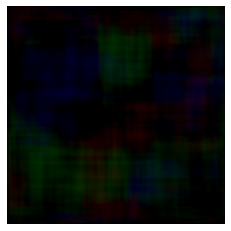

In [27]:
z_dims = cfg.GAN['Z_DIM']
noise = tf.random.normal(shape=(4, z_dims))
fake_images, foreground_images, mask_images, foreground_masks = algo.generator(noise, child_code_list[:4, :])

image = plt.figure()
ax = image.add_subplot(1,1,1)
ax.imshow(fake_images[0][1])
ax.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 125.5, 125.5, -0.5)

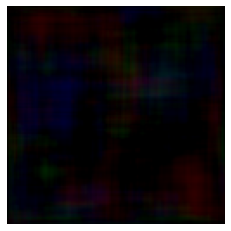

In [28]:
image = plt.figure()
ax = image.add_subplot(1,1,1)
ax.imshow(fake_images[0][2])
ax.axis("off")

In [224]:
fimgs_data = tf.data.Dataset.from_tensor_slices((fimgs_list))
cimgs_data = tf.data.Dataset.from_tensor_slices((cimgs_list))
child_code_data = tf.data.Dataset.from_tensor_slices((child_code_list))
mod_bbox_data = tf.data.Dataset.from_tensor_slices((mod_bbox_list))

fimgs_data = fimgs_data.batch(algo.batch_size).map(lambda tf_tensor: tf.cast(tf_tensor, dtype=tf.float32), num_parallel_calls=AUTOTUNE)
cimgs_data = cimgs_data.batch(algo.batch_size).map(lambda tf_tensor: tf.cast(tf_tensor, dtype=tf.float32), num_parallel_calls=AUTOTUNE)
child_code_data = child_code_data.batch(algo.batch_size).map(lambda tf_tensor: tf.cast(tf_tensor, dtype=tf.float32), num_parallel_calls=AUTOTUNE)
mod_bbox_data = mod_bbox_data.batch(algo.batch_size).map(lambda tf_tensor: tf.cast(tf_tensor, dtype=tf.float32), num_parallel_calls=AUTOTUNE)

fimgs_data = fimgs_data.cache().shuffle(1000).prefetch(2)
cimgs_data = cimgs_data.cache().shuffle(1000).prefetch(2)
child_code_data = child_code_data.cache().shuffle(1000).prefetch(2)
mod_bbox_data = mod_bbox_data.cache().shuffle(1000).prefetch(2)